# Integrated Gradients (IG) Interpretability — Examples on Experimental Data

This notebook shows how to explain the model's predictions with **Integrated Gradients (IG)**.

We use real rows from `data/processed/experimental.csv` and compute:
- Predictions (MAE encoder + regression head)
- IG feature attributions for each target


In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.constants import EXPERIMENTAL_FEATURE_COLUMNS, EXPERIMENTAL_TARGET_COLUMNS
from src.interpretability.attributions import integrated_gradients_for_prediction
from src.models.inference import auto_device, load_artifacts, predict_labels

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

MAE_CKPT = MODELS_DIR / "mae_pretrained.pth"
HEAD_CKPT = MODELS_DIR / "downstream_head.pth"
SCALER = PROCESSED_DIR / "feature_scaler.joblib"
EXPERIMENTAL = PROCESSED_DIR / "experimental.csv"

device = auto_device()
device

device(type='mps')

In [2]:
assert EXPERIMENTAL.exists(), f"Missing: {EXPERIMENTAL}. Run make_dataset first."
assert SCALER.exists(), f"Missing: {SCALER}. Run build_features first."
assert MAE_CKPT.exists(), f"Missing: {MAE_CKPT}. Train MAE first."
assert HEAD_CKPT.exists(), f"Missing: {HEAD_CKPT}. Fine-tune regression head first."

artifacts = load_artifacts(mae_path=MAE_CKPT, head_path=HEAD_CKPT, scaler_path=SCALER, device=device)
df = pd.read_csv(EXPERIMENTAL)
df.head()

/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


,TDS_gL,MLR,Light_kW_m2,Selectivity,Li_Crystallization_mg_m2_h,Evap_kg_m2_h,SampleID
0,1.0,80.0,1.0,4.24006,0.39317,1.263877,1
1,1.0,130.0,1.0,9.05684,0.20764,1.263877,2
2,1.0,300.0,1.0,11.12639,0.12903,1.263877,3
3,1.0,900.0,1.0,12.47143,0.12756,1.263877,4
4,1.0,1400.0,1.0,15.84229,0.31926,1.263877,5


## Pick a few experimental samples

We use the first few rows. If your file has an ID column, feel free to subset by ID.


In [3]:
n_show = min(3, len(df))
subset = df.iloc[:n_show].copy()

cols = list(EXPERIMENTAL_FEATURE_COLUMNS) + [c for c in EXPERIMENTAL_TARGET_COLUMNS if c in subset.columns]
subset = subset[cols]
subset

,TDS_gL,MLR,Light_kW_m2,Selectivity,Li_Crystallization_mg_m2_h,Evap_kg_m2_h
0,1.0,80.0,1.0,4.24006,0.39317,1.263877
1,1.0,130.0,1.0,9.05684,0.20764,1.263877
2,1.0,300.0,1.0,11.12639,0.12903,1.263877


## Predict targets (and compare with ground truth if available)


In [4]:
samples = subset[list(EXPERIMENTAL_FEATURE_COLUMNS)].to_dict(orient="records")

y_pred = predict_labels(artifacts, samples=samples, impute_missing_chemistry=False)
pred_df = pd.DataFrame(y_pred, columns=[f"pred_{c}" for c in EXPERIMENTAL_TARGET_COLUMNS])

out = pd.concat([subset.reset_index(drop=True), pred_df], axis=1)
out

,TDS_gL,MLR,Light_kW_m2,Selectivity,Li_Crystallization_mg_m2_h,Evap_kg_m2_h,pred_Selectivity,pred_Li_Crystallization_mg_m2_h,pred_Evap_kg_m2_h
0,1.0,80.0,1.0,4.24006,0.39317,1.263877,4.237864,0.392569,1.263373
1,1.0,130.0,1.0,9.05684,0.20764,1.263877,9.051534,0.207590,1.263358
2,1.0,300.0,1.0,11.12639,0.12903,1.263877,11.121961,0.128276,1.263506


## IG attributions

We compute IG for each sample and each target.

Notes:
- IG is computed on the **unclamped raw prediction** (to keep gradients meaningful).
- The `delta` value is a convergence check; it should be near 0.


In [5]:
steps = 64  # increase for better accuracy

igs = []
for i, s in enumerate(samples):
    ig = integrated_gradients_for_prediction(artifacts, sample=s, steps=steps)
    igs.append(ig)
    print(f"sample {i}: deltas", ig.deltas)

igs[0]

sample 0: deltas {'Selectivity': 0.00014829635620117188, 'Li_Crystallization_mg_m2_h': -5.662441253662109e-06, 'Evap_kg_m2_h': -6.062909960746765e-07}
sample 1: deltas {'Selectivity': 2.8312206268310547e-05, 'Li_Crystallization_mg_m2_h': -6.07222318649292e-07, 'Evap_kg_m2_h': -7.35744833946228e-08}
sample 2: deltas {'Selectivity': -0.0002551078796386719, 'Li_Crystallization_mg_m2_h': 1.307949423789978e-05, 'Evap_kg_m2_h': -2.998858690261841e-07}


IGAttributions(features=('TDS_gL', 'MLR', 'Light_kW_m2'), targets=('Selectivity', 'Li_Crystallization_mg_m2_h', 'Evap_kg_m2_h'), input_values={'TDS_gL': 1.0, 'MLR': 80.0, 'Light_kW_m2': 1.0}, baseline_values={'TDS_gL': 638.02978515625, 'MLR': 148.25527954101562, 'Light_kW_m2': 1.0}, attributions={'Selectivity': {'TDS_gL': 0.26118525862693787, 'MLR': -4.757768630981445, 'Light_kW_m2': 0.0}, 'Li_Crystallization_mg_m2_h': {'TDS_gL': 0.032850392162799835, 'MLR': 0.19009767472743988, 'Light_kW_m2': 0.0}, 'Evap_kg_m2_h': {'TDS_gL': -0.008999830111861229, 'MLR': -0.00035796998417936265, 'Light_kW_m2': 0.0}}, deltas={'Selectivity': 0.00014829635620117188, 'Li_Crystallization_mg_m2_h': -5.662441253662109e-06, 'Evap_kg_m2_h': -6.062909960746765e-07})

## Visualize attributions

Bar plot per target for one selected sample.


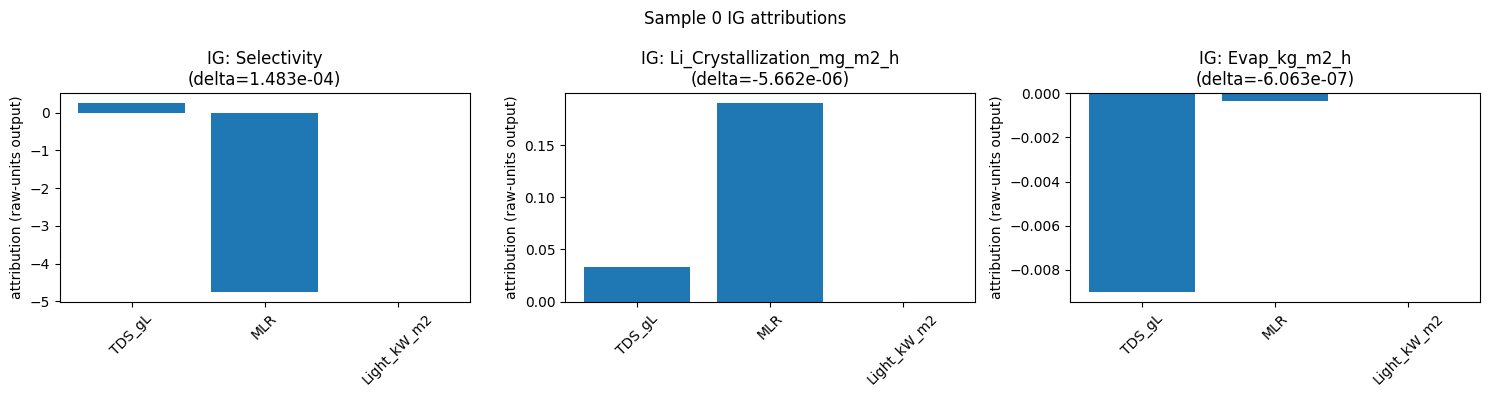

In [6]:
sample_idx = 0
ig = igs[sample_idx]

features = list(ig.features)
targets = list(ig.targets)

fig, axes = plt.subplots(1, len(targets), figsize=(5 * len(targets), 4), sharey=False)
if len(targets) == 1:
    axes = [axes]

for ax, t in zip(axes, targets):
    vals = np.array([ig.attributions[t][f] for f in features], dtype=float)
    ax.bar(features, vals)
    ax.set_title(f"IG: {t}\n(delta={ig.deltas[t]:.3e})")
    ax.tick_params(axis="x", rotation=45)
    ax.set_ylabel("attribution (raw-units output)")

plt.suptitle(f"Sample {sample_idx} IG attributions")
plt.tight_layout()
plt.show()